In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Reading data
df1 = pd.read_csv('../data/dataset.csv')
df2 = pd.read_csv('../data/TCS.BO.csv')

# Adding price column to the indicator dataset
n = df1['Date'].size
df2Close = df2['Close'].to_list()
df2Date = df2['Date'].to_list()
prices = []
for i in range(n):
    df1Date = df1['Date'].iloc[i]
    price = df2Close[df2Date.index(df1Date)]
    prices.append(price)

df1['Price'] = prices
features = df1.columns[1:-1]

# Building the final datset to be used throughout
df = pd.concat([df1['Date'],df1['Price'],df1[features]], axis=1)
df.head()

,Date,Price,Volume,AO,ROC_12,ROC_26,ROC_50,ROC_200,EMA_12,EMA_26,...,WILLR_125,VWMA_14,VWMA_20,STOCH_d,STOCH_k,SMA_12,SMA_26,SMA_50,SMA_200,Signal
0,12-11-2002,36.974998,42304,7.932132,1.405545,-1.465698,-12.588655,-3.710945,43.493023,43.816629,...,-97.498357,44.108333,42.767381,0.145167,0.035445,43.116667,43.115866,44.26300,56.377938,WAIT
1,13-11-2002,36.625000,40440,-6.857685,2.268761,-4.498041,-15.561960,-2.104907,42.436404,43.283916,...,-97.959185,43.364286,42.346964,0.035870,0.033248,43.184375,43.049519,44.12800,56.374000,BUY
2,14-11-2002,37.062500,57552,-6.955552,2.382595,-1.133709,-13.582048,-1.690983,41.609649,42.823070,...,-97.383148,42.682262,41.974107,0.034403,0.034516,43.256250,43.033173,44.01150,56.370813,WAIT
3,15-11-2002,37.937500,76520,-6.895258,3.161111,1.369408,-8.639377,-1.043369,41.044703,42.461176,...,-96.231074,42.111191,41.688869,0.035050,0.037384,43.353125,43.052885,43.93975,56.368813,WAIT
4,18-11-2002,38.325001,133176,-6.703199,2.576117,0.590557,-6.008585,-0.583654,40.626287,42.154793,...,-95.720869,41.571548,41.445774,0.037440,0.040419,43.433333,43.061539,43.89075,56.367688,WAIT


In [3]:

# Picking 10 out of these 15 based on absolute correlation and feature selection
features = ['EMV_50','WILLR_14','STOCH_k','CCI_14','WILLR_20','WILLR_125','RSI_12']
df = df[['Date','Price']+features+['Signal']]

# Data split: 70% training, 30% testing
# Since it's a time-series data, we only need to select the first 70% data points for training

X_train = df[features].iloc[0:floor(n*0.7)]
X_test = df[features].iloc[floor(n*0.7):]
y_train = df['Signal'].iloc[0:floor(n*0.7)]
y_test = df['Signal'].iloc[floor(n*0.7):]


In [4]:
df

,Date,Price,EMV_50,WILLR_14,STOCH_k,CCI_14,WILLR_20,WILLR_125,RSI_12,Signal
0,12-11-2002,36.974998,-5.776638e+02,-97.530458,0.035445,-36.258633,-97.530458,-97.498357,47.686546,WAIT
1,13-11-2002,36.625000,-6.491171e+01,-97.991437,0.033248,-36.934730,-97.991437,-97.959185,47.571058,BUY
2,14-11-2002,37.062500,6.298672e+02,-97.415210,0.034516,-34.633158,-97.415210,-97.383148,47.743634,WAIT
3,15-11-2002,37.937500,3.516253e+02,-96.262757,0.037384,-31.299253,-96.262757,-96.231074,48.116250,WAIT
4,18-11-2002,38.325001,3.449378e+02,-97.290062,0.040419,-28.898494,-95.752384,-95.720869,48.294369,WAIT
...,...,...,...,...,...,...,...,...,...,...
4316,01-06-2020,2044.650024,2.309482e+06,-7.953355,0.602482,147.710254,-7.953355,-28.495791,62.078557,WAIT
4317,02-06-2020,2046.900024,2.161437e+06,-15.934568,0.674487,162.308673,-15.934568,-28.197995,62.281001,SELL
4318,03-06-2020,2045.349976,-8.596821e+05,-16.658890,0.859530,115.121297,-16.658890,-28.403150,62.032123,BUY
4319,04-06-2020,2093.899902,1.455138e+06,-2.618068,0.907849,149.582425,-2.618068,-21.977376,66.593478,SELL


In [19]:
# using Grid Search CV to predict best hyper-parameters for Adaboost

adb_model = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['algorithm'] = ['SAMME', 'SAMME.R']


gridSearch = GridSearchCV(adb_model, grid, verbose = 3, n_jobs = -1)


In [20]:
best_adb_model = gridSearch.fit(X_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.6s finished


In [21]:
best_adb_model.best_estimator_

AdaBoostClassifier(algorithm='SAMME', n_estimators=500)

In [22]:
best_model = AdaBoostClassifier(algorithm='SAMME', n_estimators=500).fit(X_train, y_train)

In [23]:
# Accuracy of the best model as per Grid Search CV
best_model.score(X_test, y_test)

0.5674633770239013

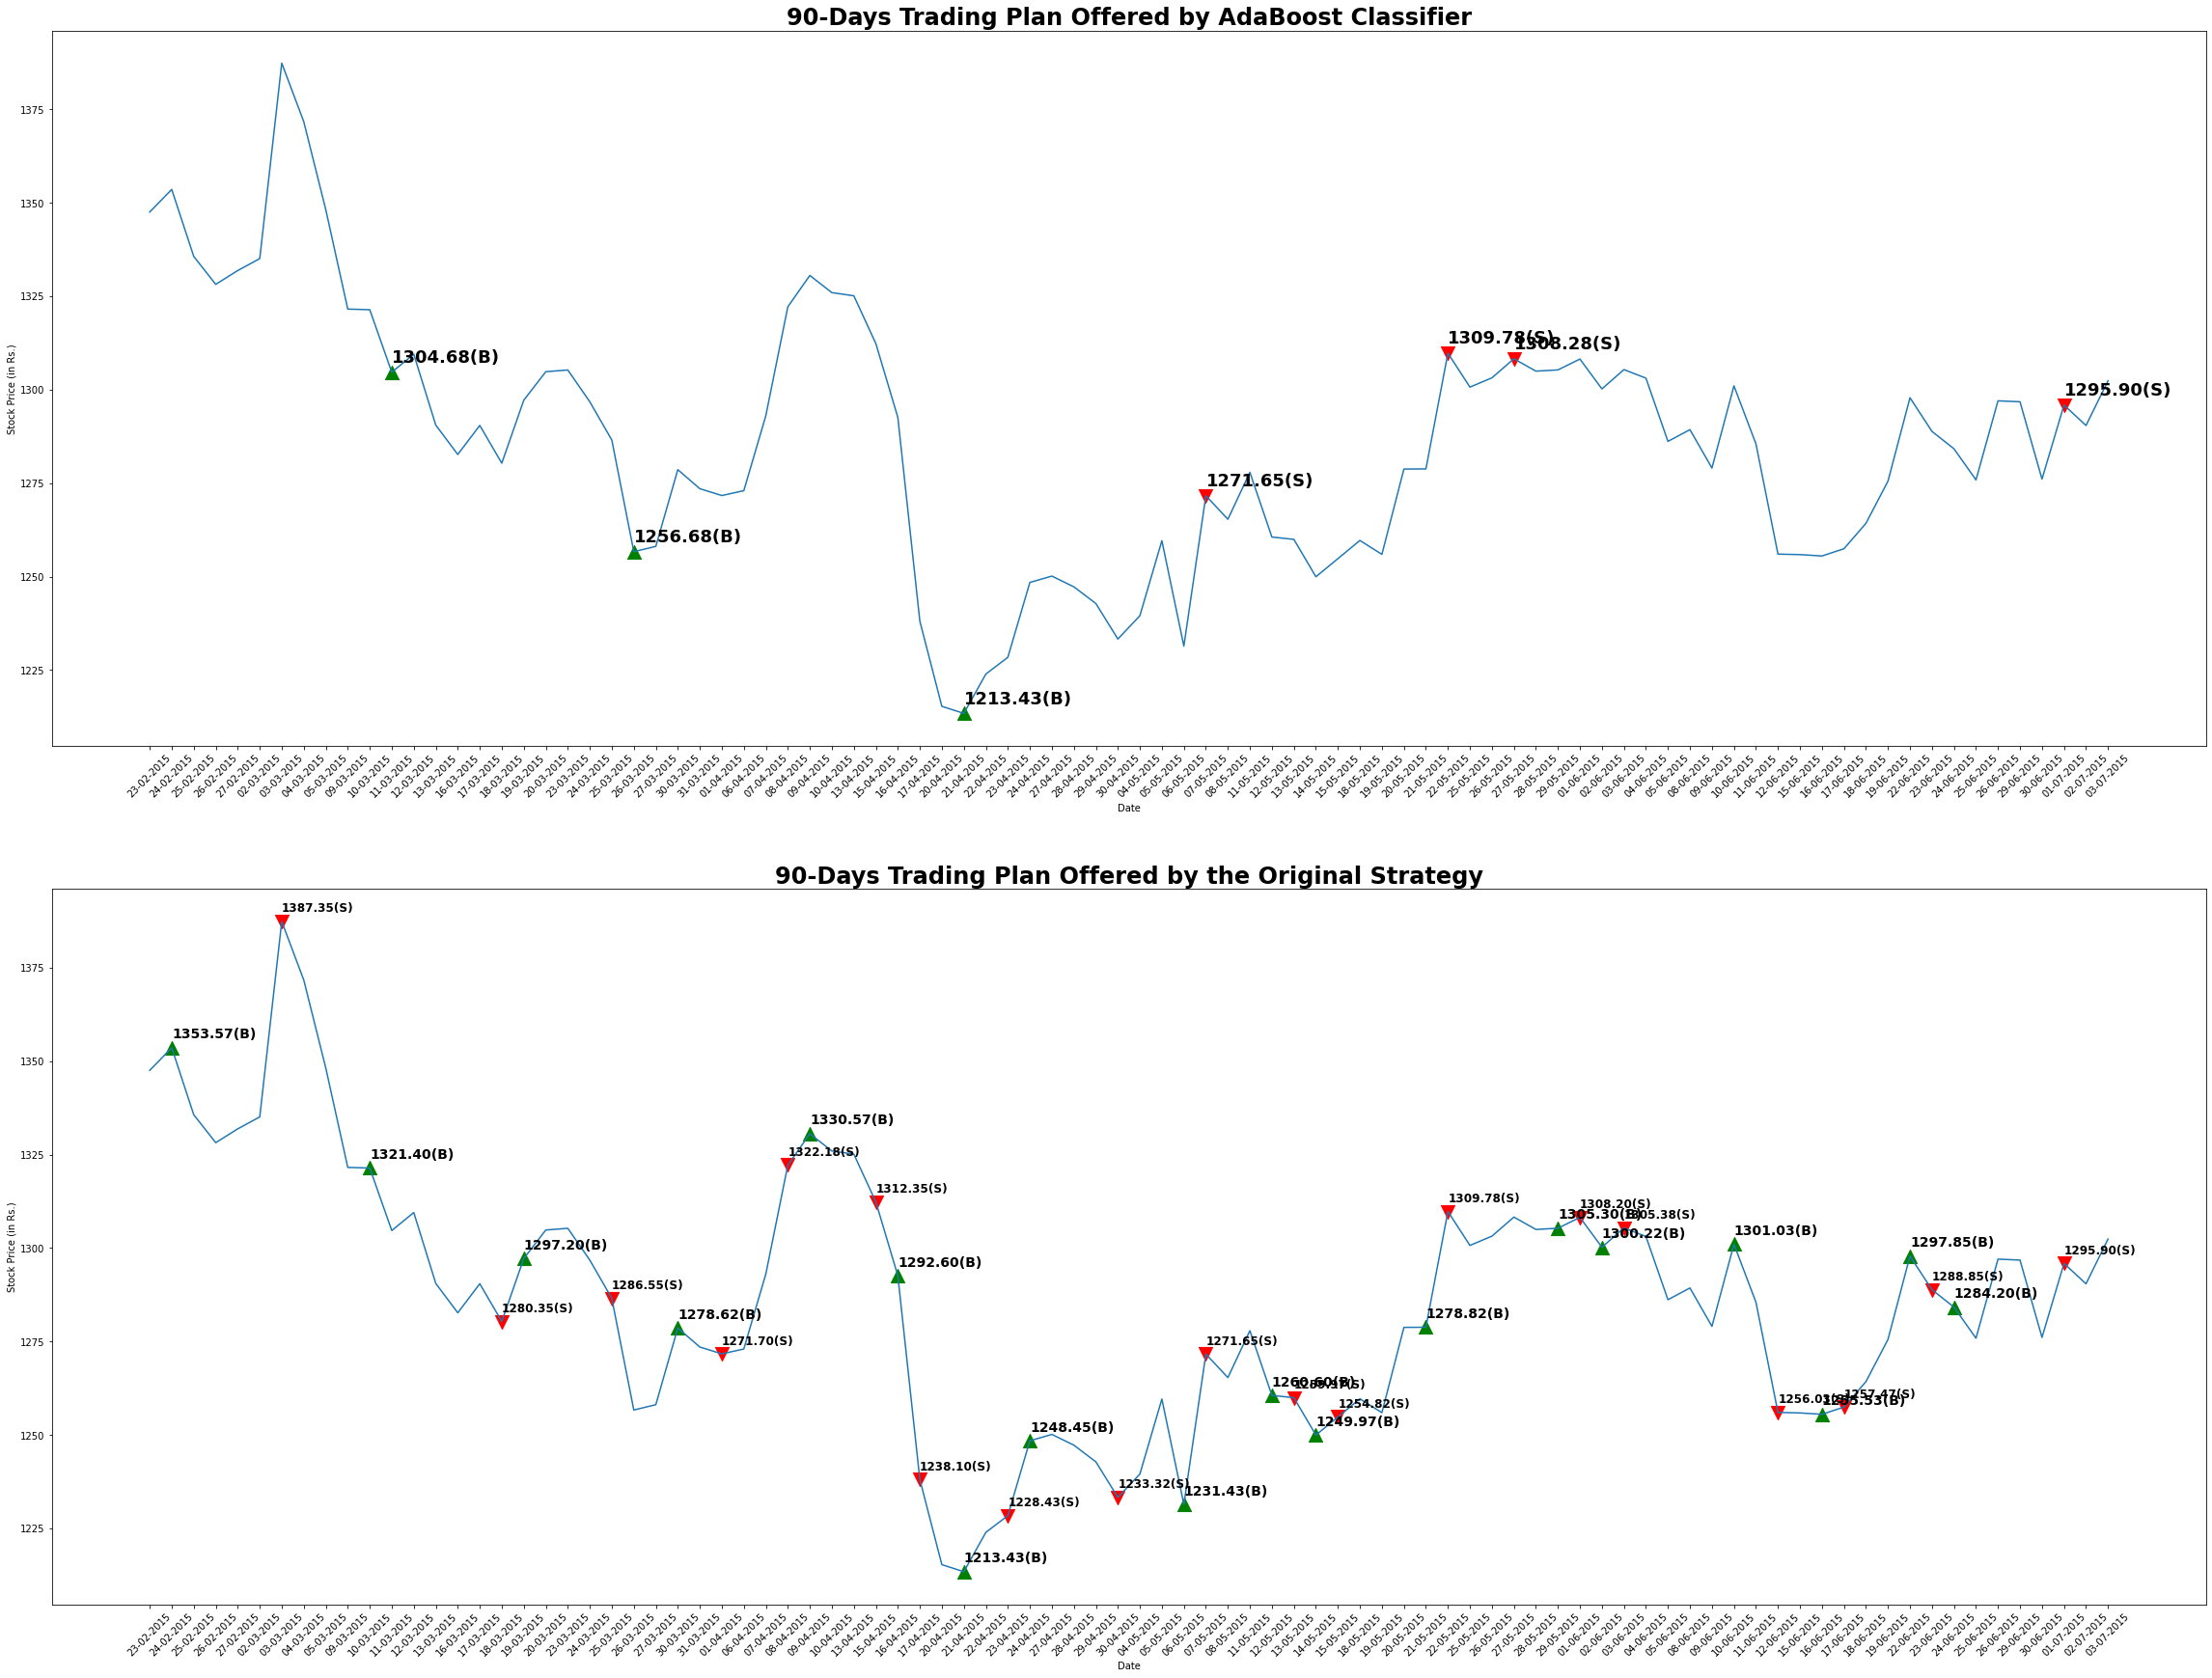

In [26]:
pred = best_model.predict(X_test) # Generating signals over test set

nDays = 90  # N-days for signal visualization
# Visualizing N-days trading plan offered by the model
fig = plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays], df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays], '-')
i = 0
for x,y in zip(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays],df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays]):
    label = pred[i]
    if(label=='WAIT'): label = ''
    elif(label=='BUY'): 
        label = '{:.2f}(B)'.format(y)
        plt.scatter(x=x, y=y, marker='^', c='g', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=18, fontweight='bold')
    else: 
        label = '{:.2f}(S)'.format(y)
        plt.scatter(x=x, y=y, marker='v', c='r', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=18, fontweight='bold')
    i = i+1
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price (in Rs.)')
plt.title('90-Days Trading Plan Offered by AdaBoost Classifier', fontsize=24, fontweight='bold')

# Visualizing N-days trading plan offered by the original strategy
plt.subplot(2,1,2)
plt.plot(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays], df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays], '-')
i = 0
for x,y in zip(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays],df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays]):
    label = df['Signal'].iloc[i]
    if(label=='WAIT'): label = ''
    elif(label=='BUY'): 
        label = '{:.2f}(B)'.format(y)
        plt.scatter(x=x, y=y, marker='^', c='g', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=14, fontweight='bold')
    else: 
        label = '{:.2f}(S)'.format(y)
        plt.scatter(x=x, y=y, marker='v', c='r', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=12, fontweight='bold')
    i = i+1
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price (in Rs.)')
plt.title('90-Days Trading Plan Offered by the Original Strategy', fontsize=24, fontweight='bold')

plt.show()